In [2]:

import warnings

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano as th
import Generative_model
from pymc3 import Model, Normal, Slice, sample, Uniform, Binomial, HalfNormal
from pymc3.distributions import Interpolated
from scipy import stats
plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


C:\Users\herma\AppData\Local\Temp\ipykernel_9936\158589786.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [4]:
# Initialize random number generator
np.random.seed(93457)

# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>]], dtype=object)

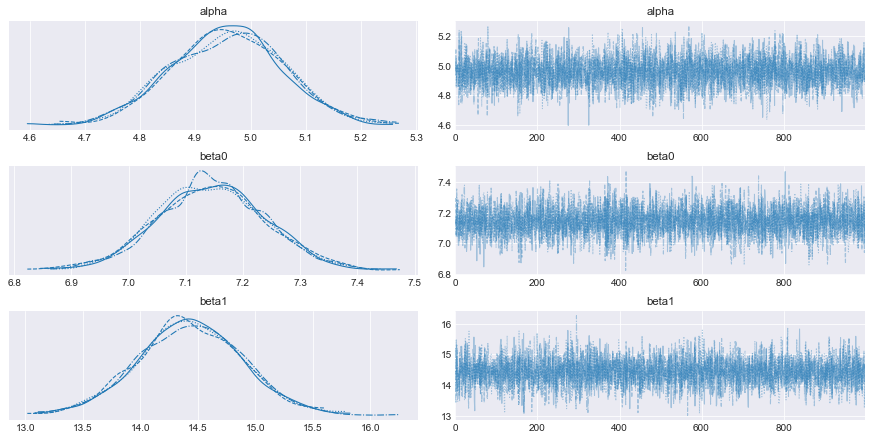

In [5]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = Normal("alpha", mu=0, sigma=1)
    beta0 = Normal("beta0", mu=12, sigma=1)
    beta1 = Normal("beta1", mu=18, sigma=1)

    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    # draw 1000 posterior samples
    trace = sample(1000)
az.plot_trace(trace)

In [6]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [7]:
traces = [trace]
for _ in range(10):
    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior("alpha", trace["alpha"])
        beta0 = from_posterior("beta0", trace["beta0"])
        beta1 = from_posterior("beta1", trace["beta1"])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)

c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


ValueError: Not enough samples to build a trace.

Posterior distributions after 8 iterations.


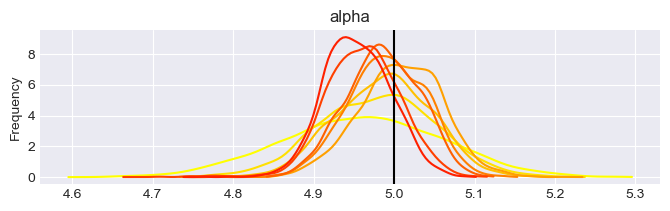

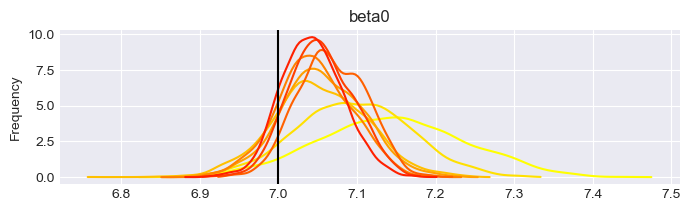

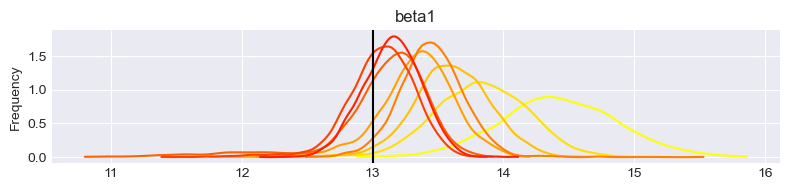

In [ ]:
print("Posterior distributions after " + str(len(traces)) + " iterations.")
cmap = mpl.cm.autumn
for param in ["alpha", "beta0", "beta1"]:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({"alpha": alpha_true, "beta0": beta0_true, "beta1": beta1_true}[param], c="k")
    plt.ylabel("Frequency")
    plt.title(param)

plt.tight_layout()

this is my attempt to recreate the model updating 

In [3]:
#generating 3 different planets of our solar system
# earth with 70 percent water, mars with 10 percent water and neptune with 99 percent water

# Generate data for Earth
Y_earth = np.random.binomial([1]*5000, 0.7)
water_obs_earth = np.cumsum(Y_earth)
total_obs_earth = range(1, 5001)

# Generate data for Mars
Y_mars = np.random.binomial([1]*5000, 0.1)
water_obs_mars = np.cumsum(Y_mars)
total_obs_mars = range(1, 5001)

# Generate data for Neptune
Y_neptune = np.random.binomial([1]*5000, 0.99)
water_obs_neptune = np.cumsum(Y_neptune)
total_obs_neptune = range(1, 5001)


In [ ]:
set_choice = np.random.randint(2, size=5000)

# Initialize lists for water observations and total observations
water_obs_nep_mar = []
total_obs_nep_mar = []

# Loop through the set_choice array and assign water observations and total observations accordingly
for choice in set_choice:
    if choice == 0:  # Set 1
        Y = np.random.binomial(1, 0.1)  # Mars parameters used
        water_obs_nep_mar.append(Y)
        total_obs_nep_mar.append(np.sum(water_obs_nep_mar))
    else:  # Set 2
        Y = np.random.binomial(1, 0.99)  # Neptune parameters used
        water_obs_nep_mar.append(Y)
        total_obs_nep_mar.append(np.sum(water_obs_nep_mar))

# Convert lists to numpy arrays
water_obs_nep_mar = np.array(water_obs_nep_mar)
total_obs_nep_mar = np.array(total_obs_nep_mar)

# Apply the same functions to the merged data uyidtó
# For example, you can calculate the cumulative sum
cumulative_water_nep_mar = np.cumsum(water_obs_nep_mar)

c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage_merged, water_percentage neptune, water_percentage mars, water_percentage earth]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 48 seconds.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'water_percentage earth'}>,
        <AxesSubplot:title={'center':'water_percentage earth'}>],
       [<AxesSubplot:title={'center':'water_percentage mars'}>,
        <AxesSubplot:title={'center':'water_percentage mars'}>],
       [<AxesSubplot:title={'center':'water_percentage neptune'}>,
        <AxesSubplot:title={'center':'water_percentage neptune'}>],
       [<AxesSubplot:title={'center':'water_percentage_merged'}>,
        <AxesSubplot:title={'center':'water_percentage_merged'}>]],
      dtype=object)

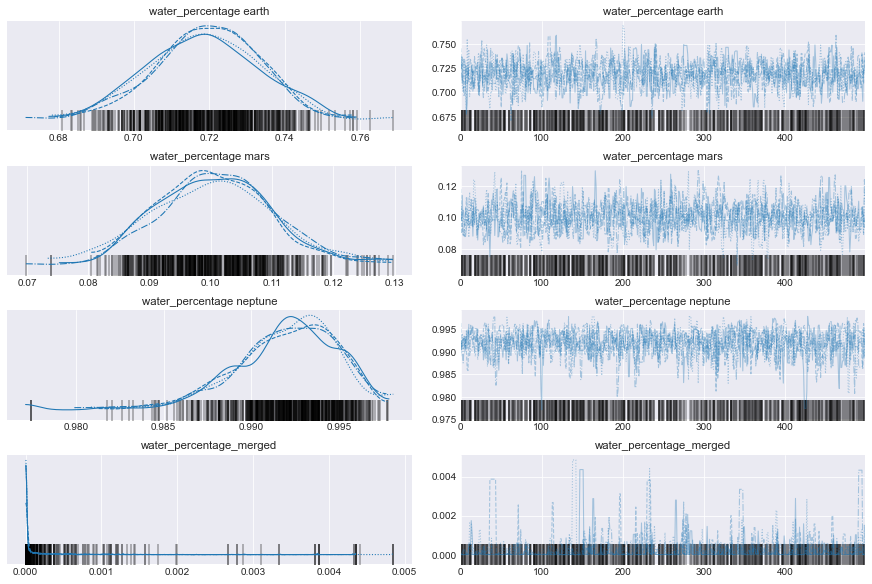

In [ ]:
model_planet = Model()
with model_planet:
    #setting up the prior for each planet to be uniform
    water_percentage_earth = pm.Beta("water_percentage earth",alpha=5,beta=2)
    water_percentage_mars = pm.Beta("water_percentage mars",alpha=5,beta=2)
    water_percentage_neptune = pm.Beta("water_percentage neptune",alpha=5,beta=2)

    #trying to combine the data seems not effective
    water_percentage_merged = pm.Beta("water_percentage_merged",  alpha=water_percentage_mars,beta=water_percentage_neptune)
    #observing seperately what the estimation is
    
    Y_obs_mars = Binomial("Y_obs_mars",n=total_obs_mars[1000],p=water_percentage_mars,observed=water_obs_mars[1000])
    Y_obs_neptune = Binomial("Y_obs_neptune",n=total_obs_neptune[1000],p=water_percentage_neptune,observed=water_obs_neptune[1000])

    #attempt to combine 2 variables in one beta function and observe using mixed data no proper results also slows down process
    Y_obs_merged = Binomial("Y_obs_neptune_mars",n=total_obs_nep_mar[1000],p=water_percentage_merged,observed=water_obs_nep_mar[1000])
    #sampling from each observed variable
    
    trace = sample(500,cores=4)

    #I don't know how to convolute these curves to form a whole yet.
az.plot_trace(trace)


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage_neptune, water_percentage_earth, Oxygen_count, Hy

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 32 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Hydrogen_count'}>,
        <AxesSubplot:title={'center':'Hydrogen_count'}>],
       [<AxesSubplot:title={'center':'Oxygen_count'}>,
        <AxesSubplot:title={'center':'Oxygen_count'}>],
       [<AxesSubplot:title={'center':'water_percentage_earth'}>,
        <AxesSubplot:title={'center':'water_percentage_earth'}>],
       [<AxesSubplot:title={'center':'water_percentage_neptune'}>,
        <AxesSubplot:title={'center':'water_percentage_neptune'}>]],
      dtype=object)

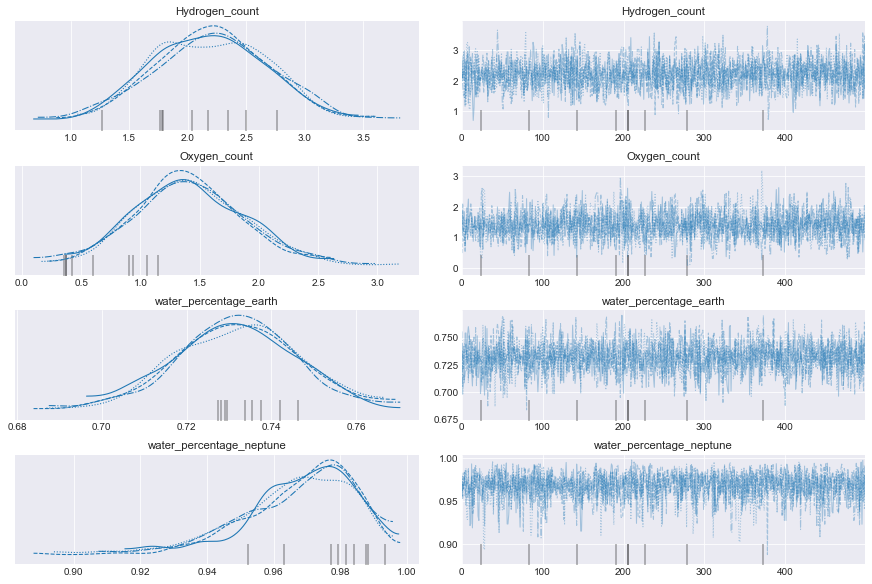

In [9]:
import arviz as az

model_planet_2 = Model()
with model_planet_2:
    #not certain if these get properly back updated?
    Hydrogen_count = Normal("Hydrogen_count",2,0.5)
    Oxygen_count = Normal("Oxygen_count",2,0.5)
    
    #what word er precies afgehaald? std mean probably mean
    #trial_link_function = Hydrogen_count-Oxygen_count
    #trial_link_function_disp = pm.Normal("trial_link_function_disp",mu=trial_link_function)
    
    water_percentage_earth = pm.Beta("water_percentage_earth", alpha=Hydrogen_count, beta=Oxygen_count)
    water_percentage_neptune = pm.Beta("water_percentage_neptune", alpha=Hydrogen_count, beta=Oxygen_count)

    Y_obs_earth = Binomial("Y_obs_earth", n=total_obs_earth[1000], p=water_percentage_earth, observed=water_obs_earth[1000])
    Y_obs_neptune = Binomial("Y_obs_neptune", n=total_obs_neptune[100], p=water_percentage_neptune, observed=water_obs_neptune[100])
    
    trace = sample(500, cores=4)

# Plotting trace for water_percentage
az.plot_trace(trace)

In [7]:
print(az.summary(trace))

c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Hydrogen_count            0.855  0.380   0.190    1.556      0.011    0.008   
Oxygen_count              0.436  0.222   0.074    0.840      0.008    0.005   
water_percentage_earth    0.732  0.015   0.705    0.759      0.000    0.000   
water_percentage_neptune  0.989  0.003   0.983    0.994      0.000    0.000   

                          ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count              1207.0  1133.0    1195.0    1004.0    1.0  
Oxygen_count                 873.0   873.0     817.0     785.0    1.0  
water_percentage_earth      1338.0  1337.0    1325.0    1045.0    1.0  
water_percentage_neptune    1402.0  1400.0    1331.0    1096.0    1.0  


In [4]:
#test to see diference in posterior
traces = []
value_count = []
import arviz as az
for i in range(1,999,100):
    value_count.append(i)
    model_planet_2 = Model()
    with model_planet_2:

        #these values don't seem to particularly update?
        Hydrogen_count = Normal("Hydrogen_count",0.5,0.1)
        Oxygen_count = Normal("Oxygen_count",0.5,0.1)
        #what word er precies afgehaald? std mean probably mean
        #trial_link_function = Hydrogen_count-Oxygen_count
        #trial_link_function_disp = pm.Normal("trial_link_function_disp",mu=trial_link_function)
        water_percentage = pm.Beta("water_percentage", alpha=Hydrogen_count, beta=Oxygen_count)
        Y_obs_earth = Binomial("Y_obs_earth", n=total_obs_earth[i], p=water_percentage, observed=water_obs_earth[i])
        Y_obs_neptune = Binomial("Y_obs_neptune", n=total_obs_neptune[i], p=water_percentage, observed=water_obs_neptune[i])
        
        trace = sample(500, cores=4)

    # Plotting trace for water_percentage
    traces.append(trace)


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage, Oxygen_count, Hydrogen_count]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 24 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 22 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 22 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 24 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 24 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\distributions\continuous.py:140: UserWarning: The variable specified for beta has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess s

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 25 seconds.


TypeError: must be str, not int

In [5]:
for i in range(len(traces)):
    print("for " + str(value_count[i])+ "amount of samples we got the following values:")
    print(az.summary(traces[i]))

for 1amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.511  0.099   0.326    0.694      0.002    0.001    2514.0   
Oxygen_count      0.499  0.100   0.310    0.677      0.002    0.001    2259.0   
water_percentage  0.699  0.186   0.360    0.989      0.004    0.003    2303.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2457.0    2514.0    1537.0    1.0  
Oxygen_count      2216.0    2282.0    1242.0    1.0  
water_percentage  2191.0    2116.0    1275.0    1.0  
for 101amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.514  0.099   0.327    0.699      0.002    0.001    2698.0   
Oxygen_count      0.498  0.100   0.311    0.683      0.002    0.001    2851.0   
water_percentage  0.826  0.028   0.774    0.877      0.001    0.000    3016.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2587.0    2707.0    1544.0    1.0  
Oxygen_count      2818.0    2845.0    1712.0    1.0  
water_percentage  3016.0    2995.0    1534.0    1.0  
for 201amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.509  0.095   0.340    0.690      0.002    0.001    2976.0   
Oxygen_count      0.495  0.102   0.321    0.695      0.002    0.001    2329.0   
water_percentage  0.844  0.018   0.809    0.877      0.000    0.000    3046.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2946.0    2954.0    1398.0    1.0  
Oxygen_count      2312.0    2312.0    1613.0    1.0  
water_percentage  3046.0    3054.0    1420.0    1.0  
for 301amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.513  0.099    0.33    0.691      0.002    0.001    3082.0   
Oxygen_count      0.500  0.100    0.32    0.688      0.002    0.001    2538.0   
water_percentage  0.837  0.016    0.81    0.868      0.000    0.000    2967.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2814.0    3095.0    1519.0    1.0  
Oxygen_count      2433.0    2546.0    1698.0    1.0  
water_percentage  2967.0    2963.0    1400.0    1.0  
for 401amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.511  0.103   0.328    0.696      0.002    0.001    2782.0   
Oxygen_count      0.497  0.098   0.316    0.678      0.002    0.001    3139.0   
water_percentage  0.838  0.013   0.815    0.861      0.000    0.000    2772.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2539.0    2837.0    1509.0    1.0  
Oxygen_count      3014.0    3124.0    1445.0    1.0  
water_percentage  2772.0    2784.0    1597.0    1.0  
for 501amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.511  0.097   0.334    0.690      0.002    0.001    2853.0   
Oxygen_count      0.498  0.101   0.319    0.699      0.002    0.001    3153.0   
water_percentage  0.844  0.011   0.823    0.865      0.000    0.000    2723.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2819.0    2856.0    1571.0    1.0  
Oxygen_count      2950.0    3173.0    1626.0    1.0  
water_percentage  2719.0    2700.0    1675.0    1.0  
for 601amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.510  0.098   0.338    0.708      0.002    0.001    2414.0   
Oxygen_count      0.496  0.099   0.316    0.677      0.002    0.001    2778.0   
water_percentage  0.848  0.011   0.827    0.867      0.000    0.000    2871.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2323.0    2384.0    1299.0    1.0  
Oxygen_count      2659.0    2782.0    1662.0    1.0  
water_percentage  2871.0    2894.0    1243.0    1.0  
for 701amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.513  0.100   0.324    0.694      0.002    0.001    2840.0   
Oxygen_count      0.495  0.102   0.302    0.676      0.002    0.002    2347.0   
water_percentage  0.848  0.010   0.831    0.867      0.000    0.000    2575.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2765.0    2840.0    1495.0    1.0  
Oxygen_count      2253.0    2360.0    1611.0    1.0  
water_percentage  2567.0    2507.0    1493.0    1.0  
for 801amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.513  0.099   0.320    0.691      0.002    0.001    2252.0   
Oxygen_count      0.497  0.101   0.302    0.680      0.002    0.001    2772.0   
water_percentage  0.846  0.009   0.829    0.863      0.000    0.000    2222.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2198.0    2251.0    1624.0    1.0  
Oxygen_count      2668.0    2775.0    1620.0    1.0  
water_percentage  2222.0    2224.0    1393.0    1.0  
for 901amount of samples we got the following values:


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Hydrogen_count    0.513  0.098   0.338    0.709      0.002    0.001    2852.0   
Oxygen_count      0.496  0.099   0.324    0.691      0.002    0.001    2739.0   
water_percentage  0.848  0.009   0.832    0.863      0.000    0.000    2796.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
Hydrogen_count    2712.0    2848.0    1495.0    1.0  
Oxygen_count      2534.0    2751.0    1560.0    1.0  
water_percentage  2796.0    2782.0    1448.0    1.0  


# Data generation
The samples per degree is made proportional meaning that it is a percentage based on all the times 1 is noted down in the bernuli draw of raw data



In [55]:
#generate data per degree
mu,sigma = 1,2
def cumulative_normal(x, mean, sigma, s=np.sqrt(2)):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * tt.erf((x-mean)/(sigma*s))

normal_dist = stats.norm(loc = mu, scale=sigma)
n_samples = 1
chance_per_degree = []
samples_per_degree = []
samples_per_degree_obs = []
y_cord = []

stimuli = np.arange(-8,9)

p=normal_dist.cdf(stimuli)

responses = np.random.binomial(n_samples,p=normal_dist.cdf(stimuli))
print(responses)
proportional_responses = [i/n_samples for i in responses]
print(proportional_responses)


[0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]


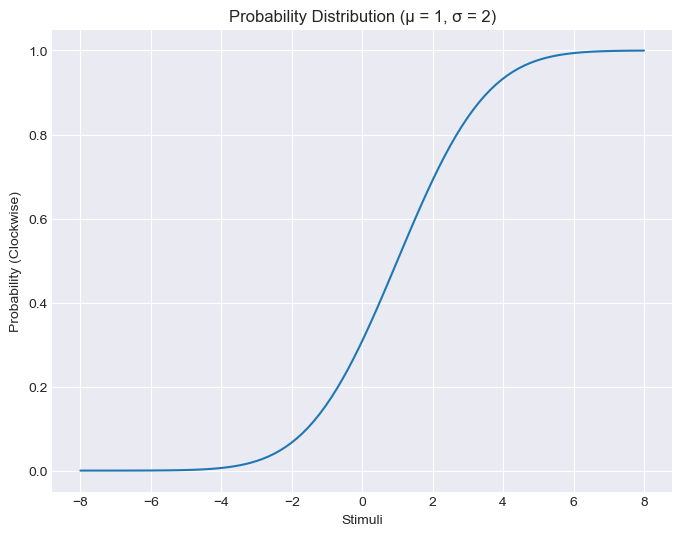

In [56]:
# Define parameters

# Stimuli values from -8 to 8
x = np.linspace(-8, 8, 100)

# Generate probabilities using normal distribution CDF
normal_distribution = stats.norm(loc=mu, scale=sigma)
data = normal_distribution.cdf(x)
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, data)
plt.title('Probability Distribution (μ = 1, σ = 2)')
plt.xlabel('Stimuli')
plt.ylabel('Probability (Clockwise)')
plt.grid(True)
plt.show()

### function

this code block concerns itself about generating new random data


In [66]:
def generate_random_data(amount):
    responses = np.random.binomial(amount,p=normal_dist.cdf(stimuli))
    return amount,responses


# Model
 


In [5]:
Global_variable_counter = 0

for some reason when we use proportional data it goes wickety wack?

c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 27 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the mod

0.582 3.285


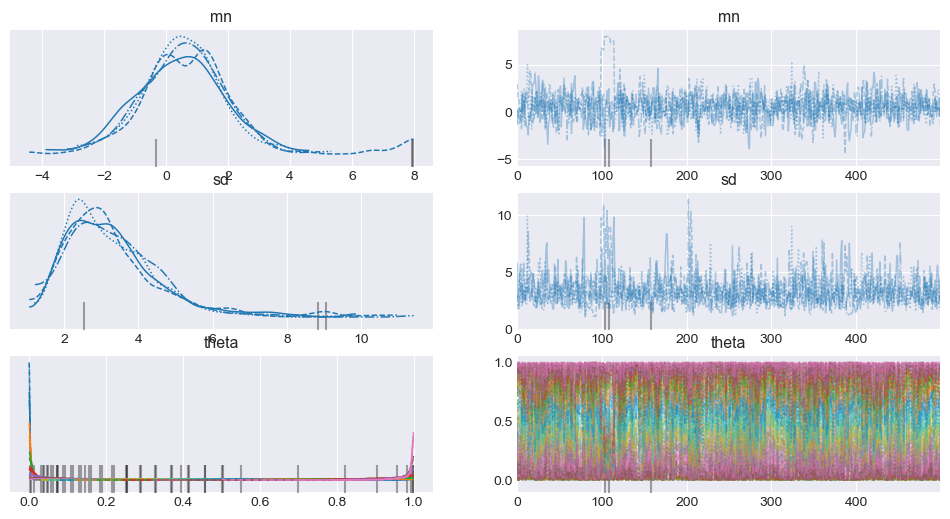

In [67]:
model_cdf_hierarchical = pm.Model()

with model_cdf_hierarchical:
    curve_mean = pm.Uniform('mn', lower=-8, upper =8)#pm.Normal("curve_mu",mu=0,sigma=5)
    curve_std =pm.Gamma("sd",alpha=3,beta=1)#pm.HalfNormal("curve_sigma",sigma=1.5)
    #curve = pm.Beta("curve", alpha=curve_mean, beta=curve_std)
    
        
    theta = pm.Deterministic('theta', cumulative_normal(stimuli,curve_mean,curve_std))
    Y_obs = pm.Binomial("Y_obs", n=n_samples, p=theta, observed=responses)
    trace_hierarchical = pm.sample(500, cores=4)  # Sampling from the model
az.plot_trace(trace_hierarchical)   
df_0 = az.summary(trace_hierarchical)
mean_value_0 = df_0.loc["mn", "mean"]
sd_value_0 = df_0.loc["sd", "mean"]
print(mean_value_0,sd_value_0)

### providing new data
important notes to make is that no variable name within the model (the string that is attached to each distribution) is allowed to be named the same meaning that a global variable counter.

c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


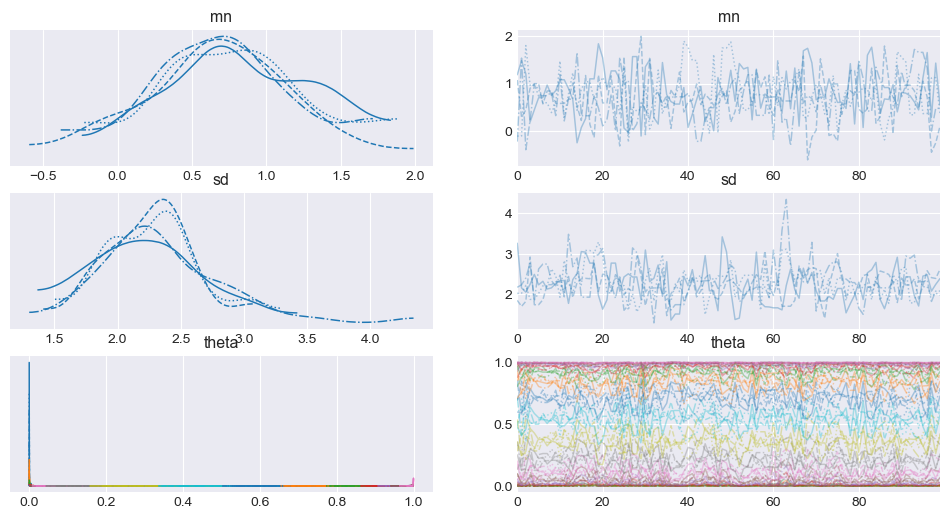

In [68]:
n_samples_new,new_data = generate_random_data(5)
with model_cdf_hierarchical:
    Y_obs = pm.Binomial("Y_obs"+str(Global_variable_counter), n=n_samples_new, p=theta, observed=new_data)
    
    trace_hierarchical = pm.sample(100, cores=4)  # Sampling from the model

az.plot_trace(trace_hierarchical)   
Global_variable_counter =+ 1

## Entropy
this code block will concern itself with calculating entropy


first we will use a trial version where we create 3 mu and sigma pairs with one being the "true" pair. 
important variable notes
lambda: the mu,sigma pairs
x: what degree we are at 
r: either 1 or 0 and that is the response chance

In [43]:
#fix actual looping 
lambda_list = [(1,2),(2,0.5),(1,2)]
#a 3d matrix that saves the h of each point 
entropy = np.zeros((len(range(-8,9)),2))
#why is it above 1 is that possible? 
for x in range(-8,9):
    for r in range(0,2):
        if r == 1: 
            #merged formula for step 1 2 and 3  
            entropy[x][r] = -sum([stats.norm(i[0], i[1]).cdf(x)/sum([stats.norm(j[0], j[1]).cdf(x) for j in lambda_list])
                                *np.log(stats.norm(i[0], i[1]).cdf(x)/sum([stats.norm(j[0], j[1]).cdf(x) for j in lambda_list])) for i in lambda_list])
        else:
            entropy[x][r] = -sum([(1 - stats.norm(i[0], i[1]).cdf(x))/sum([(1 - stats.norm(j[0], j[1]).cdf(x)) for j in lambda_list])
                     * np.log((1 - stats.norm(i[0], i[1]).cdf(x))/sum([(1 - stats.norm(j[0], j[1]).cdf(x)) for j in lambda_list])) for i in lambda_list])

print(entropy)




# mu_true, sigma_true = 1,2
# #step 1
# for i in range(len(R_X_list)):
#     #something goes wrong here since it all takes on the same value of 1.5 which is also impossible for a probability
#     cdf_sum = sum([stats.norm(j[0], j[1]).cdf(i) for j in lambda_list])
#     R_X_list[i][0] = cdf_sum
#     cdf_sum = sum([1-stats.norm(j[0], j[1]).cdf(i) for j in lambda_list])
#     R_X_list[i][1] = cdf_sum
# #step 2
# p_t_l_r = []#how to add markers 

        
#  #step 3
        


# #step 1

# pt_r_x_list = []
# degrees = range(-8,9)
# # for l in lambda_list: #l of lambda
   
# p_r1_x0 = sum([stats.norm(i[0],i[1]).cdf(0) for i in lambda_list]) 

# #step 2
# p_lambda_r1_x0 = stats.norm(lambda_list[0][0],lambda_list[0][1]).cdf(0)/p_r1_x0

# #step 3
# H_x_r = -p_lambda_r1_x0*np.log(p_lambda_r1_x0)





[[1.08244873 0.69366986]
 [1.04364223 0.78437741]
 [1.07054128 1.08786246]
 [0.89232143 1.09604298]
 [0.69519806 1.09807364]
 [0.69314757 1.09855315]
 [0.69314718 1.09860797]
 [       nan 1.09861209]
 [       nan 1.09861228]
 [1.09861229 0.69314718]
 [1.09861229 0.69314718]
 [1.09861228 0.69314718]
 [1.09861209 0.69314718]
 [1.09860797 0.69314718]
 [1.09855315 0.69314718]
 [1.09807314 0.69314718]
 [1.09517787 0.69314724]]


C:\Users\herma\AppData\Local\Temp\ipykernel_9936\3658480622.py:14: RuntimeWarning: divide by zero encountered in log
  * np.log((1 - stats.norm(i[0], i[1]).cdf(x))/sum([(1 - stats.norm(j[0], j[1]).cdf(x)) for j in lambda_list])) for i in lambda_list])
C:\Users\herma\AppData\Local\Temp\ipykernel_9936\3658480622.py:13: RuntimeWarning: invalid value encountered in double_scalars
  entropy[x][r] = -1*sum([(1 - stats.norm(i[0], i[1]).cdf(x))/sum([(1 - stats.norm(j[0], j[1]).cdf(x)) for j in lambda_list])


## Visualisation of the results for interpetation

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


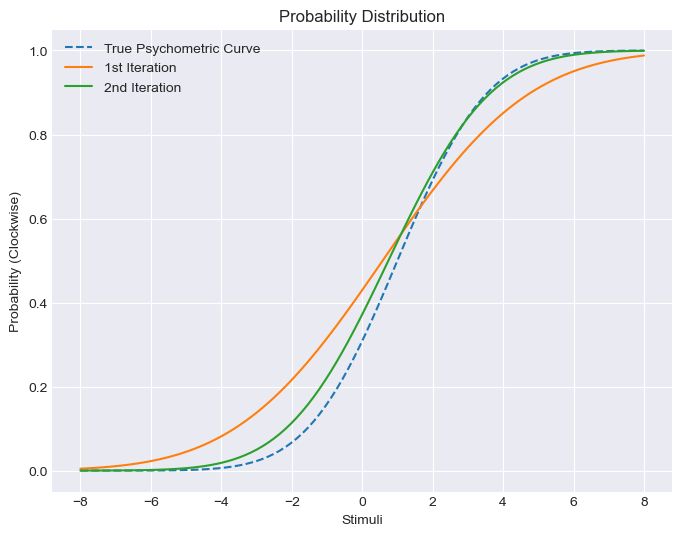

In [69]:
df = az.summary(trace_hierarchical)
mean_value_1 = df.loc["mn", "mean"]
sd_value_1 = df.loc["sd", "mean"]


x = np.linspace(-8, 8, 100)

# Generate probabilities using normal distribution CDF
normal_distribution = stats.norm(loc=mu, scale=sigma)
normal_distribution_0 = stats.norm(loc=mean_value_0, scale=sd_value_0)
normal_distribution_1 = stats.norm(loc=mean_value_1, scale=sd_value_1)


data = normal_distribution.cdf(x)
data_0 = normal_distribution_0.cdf(x)
data_1 = normal_distribution_1.cdf(x)

# Plotting
plt.figure(figsize=(8, 6))

# Plot true psychometric curve (normal_distribution)
plt.plot(x, data, linestyle='--', label='True Psychometric Curve')

# Plot 1st iteration (normal_distribution_0)
plt.plot(x, data_0,  label='1st Iteration')

# Plot 2nd iteration (normal_distribution_1)
plt.plot(x, data_1,  label='2nd Iteration')

plt.title('Probability Distribution')
plt.xlabel('Stimuli')
plt.ylabel('Probability (Clockwise)')
plt.legend()
plt.grid(True)
plt.show()

## entropy
this block will be my attempt at entropy
currently things that aren't clear is what theta is in the first step of sum_theta p(theta)P(r_x|theta)
R_x I imagine is what we expect that any given degree is. I suspect that theta is something with the cdf maybe @luc can tell me some more about this?

this is with the idea that using the expected value calculations from the papers are similar to what the product requires
papers:
1. baysian adaptive estimation of psychometric slope and threshold
2. Baysian adaptive estimation: The next dimension  ~personal note: this feels like  a title of the 26th book in a super dense sci-fi series called "the baysian adaptive estimations" and I think that's kinda neat
alternative title suggestions: 
Baysian adaptive estimation: Dimensional drifting. 
Baysian adaptive estimations: into the multiverse

the steps mathematically written out in here for convenience:
1. compute p(r_x|theta) for all discretized values of x, theta with r_x being 1 or 0 
2. sum_theta p(theta)P(r_x|theta)
3. H_t(Theta|r_x) = -sum_theta p_t(theta|r_x)log(p_t(theta|r_x)) for all x 



c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [curve]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 36 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'curve'}>,
        <Axes: title={'center': 'curve'}>]], dtype=object)

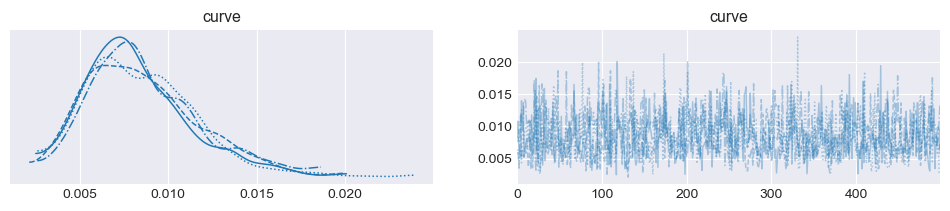

In [43]:
model_cdf_beta = pm.Model()

with model_cdf_beta:
    
    curve = pm.Beta("curve", alpha=5, beta=2)
    for i in range(0, 16):

        Y_obs = pm.Binomial("Y_obs"+str(i), n=50, p=curve, observed=samples_per_degree[i])
    trace_beta = pm.sample(500, cores=4)  # Sampling from the model
az.plot_trace(trace_beta) 
   

In [44]:
df = az.summary(trace_beta)
print(df)
# Extract mean and sigma values
mean_value_beta = df.loc["curve", "mean"]
sd_value_beta = df.loc["curve", "sd"]


Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
curve  0.008  0.003   0.003    0.014        0.0      0.0     887.0    1199.0   

       r_hat  
curve   1.01  


In [29]:
model_cdf_hierarchical = pm.Model()

with model_cdf_hierarchical:
    curve_mean = pm.Normal("curve_mu",mu=0.5,sigma=0.5)
    curve_std = pm.HalfNormal("curve_sigma",sigma=0.5)
    curve = pm.Beta("curve", alpha=curve_mean, beta=curve_std)
    for i in range(0, 16):
        
        Y_obs = pm.Binomial("Y_obs"+str(i), n=50, p=curve, observed=samples_per_degree_obs[i])
    trace_hierarchical = pm.sample(500, cores=4)  # Sampling from the model
az.plot_trace(trace_hierarchical)    

c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for alpha has negative support for Beta, likely making it unsuitable for this parameter.
  warnings.warn(msg)


IndexError: list index out of range

This code block has an effective baysian cdf model for one iteration the next step is to update the model with more data

In [47]:
df = az.summary(trace_hierarchical)
print(df)
# Extract mean and sigma values
mean_value_hierarchical = df.loc["curve_mu", "mean"]
sd_value_hierarchical = df.loc["curve_sigma", "mean"]


Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
curve_mu     0.714  0.371   0.089    1.365      0.013    0.010     788.0   
curve_sigma  0.543  0.323   0.021    1.139      0.009    0.006     988.0   
curve        0.449  0.013   0.426    0.473      0.000    0.000    1039.0   

             ess_tail  r_hat  
curve_mu       1096.0   1.00  
curve_sigma     656.0   1.01  
curve          1243.0   1.00  


This code block concerns itself with retooling the systems seen above to make the beta distribution used a cdf. For this we will use two variables which is the hierarchical model.

I have figured out what goes wrong with the type conversion. however I'm still unsure how to properly implement the function since anything above 1 gives an error so to "fix" it I have split 1 by 16 with the idea
that every degree has that point. 



In [4]:
model_cdf = pm.Model()
#trying to type cast to theano variable
def theano_conversion(x):
    return tt.cast(x, 'float64')
with model_cdf:
    curve_mean = pm.Normal("curve_mu",mu=0.5,sigma=0.5)
    curve_std = pm.HalfNormal("curve_sigma",sigma=0.5)


    Y_obs = pm.Binomial("Y_obs"+str(i), n=50, p=prob, observed=50*samples_per_degree[i])
    trace_hierarchical = pm.sample(500, cores=4)  # Sampling from the model
az.plot_trace(trace_hierarchical)


Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0
Elemwise{add,no_inplace}.0


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'curve_mu': array(0.5), 'curve_sigma_log__': array(-0.91893853)}

Initial evaluation results:
curve_mu              -0.23
curve_sigma_log__     -0.77
Y_obs0                 0.00
Y_obs1                 0.00
Y_obs2                 0.00
Y_obs3                 0.00
Y_obs4                 0.00
Y_obs5                 -inf
Y_obs6                 -inf
Y_obs7               -83.98
Y_obs8               -26.89
Y_obs9               -40.82
Y_obs10             -238.93
Y_obs11                -inf
Y_obs12                0.00
Y_obs13                -inf
Y_obs14                0.00
Y_obs15                0.00
Name: Log-probability of test_point, dtype: float64

In [25]:

output_beta = stats.norm(loc=mean_value_beta, scale=sd_value_beta)
chance_per_degree_output_beta = []
degrees_output_beta = np.linspace(-8, 8, 1000)

for degree in degrees_output_beta:
    chance_per_degree_output_beta.append(output_beta.cdf(degree))

mu, sigma = Generative_model.analytical_solution(1, 20, 0.1, 1, 0)
normal_dist = stats.norm(loc=mu, scale=sigma)
chance_per_degree_gen = []
degrees_gen = np.linspace(-8, 8, 1000)

for degree in degrees_gen:
    chance_per_degree_gen.append(normal_dist.cdf(degree))

output_hierarchical = stats.norm(loc=mean_value_hierarchical, scale=sd_value_hierarchical)
chance_per_degree_output_hierarchical = []
degrees_output_hierarchical = np.linspace(-8, 8, 1000)

for degree in degrees_output_hierarchical:
    chance_per_degree_output_hierarchical.append(output_hierarchical.cdf(degree))


plt.plot(degrees_gen, chance_per_degree_gen, label='Generative model',linestyle='--')
plt.plot(degrees_output_beta, chance_per_degree_output_beta, label='Output beta')
plt.plot(degrees_output_hierarchical, chance_per_degree_output_hierarchical, label='Output hierarchical')

plt.xlabel('Y Coordinate')
plt.ylabel('Cumulative Probability')
plt.title('CDF Comparison')
plt.grid(True)
plt.legend()
plt.show()

#waarom is hij scheef is dit goed genoeg? 
#is het beter om het hierarchies te gebruiken
#moet ik werken aan de snelheid van de sampling?


NameError: name 'mean_value_hierarchical' is not defined

[   1    2    2 ... 3473 3474 3474]
5000


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 495 draw iterations (4_000 + 1_980 draws total) took 18 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


1


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8969916671707588, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


2


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 18 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


3


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


KeyboardInterrupt: 

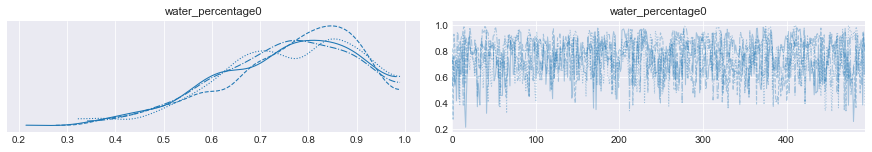

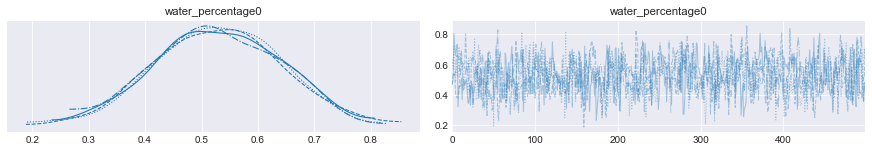

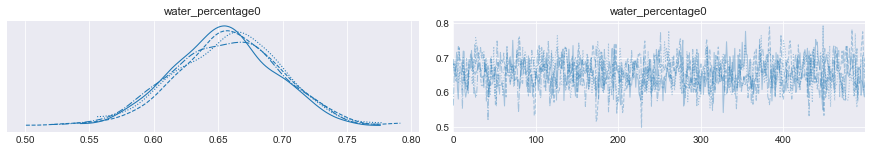

In [42]:

Y =  np.random.binomial([1]*5000,0.7)
water_obs =  np.cumsum(Y)
total_obs = range(1,5000,1)

print(len(Y))

traces = []
vector = np.array([1,10, 100, 500,1000])
model_earth = Model()
with model_earth:
    #water_percentage = Uniform("water_percentage",0,1)
    water_percentage = pm.Beta("water_percentage"+str(0),alpha=5,beta=2)
    #water_percentage_det = pm.Deterministic("water_percentage_det",water_percentage)
    #Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    Y_obs = Binomial("Y_obs"+str(0),n=1,p=water_percentage,observed=Y[0:vector[0]])

    trace = sample(500)
    traces.append(trace)
az.plot_trace(trace)  
for n in range(1,len(vector)):

    print(n)
    with model_earth:
         Y_obs = Binomial("Y_obs"+str(n),n=total_obs[vector[n]],p=water_percentage,observed=water_obs[vector[n]])
         trace = sample(500)
         traces.append(trace)
        

    az.plot_trace(trace)    
    

In [ ]:
traces = []
vector = np.array([1,10, 100, 500,1000])
model_earth = Model()
with model_earth:
    #water_percentage = Uniform("water_percentage",0,1)
    water_percentage = pm.Beta("water_percentage"+str(0),alpha=5,beta=2)
    #water_percentage_det = pm.Deterministic("water_percentage_det",water_percentage)
    #Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    Y_obs = Binomial("Y_obs"+str(0),n=1,p=water_percentage,observed=Y[0:vector[0]])

    trace = sample(500)
    traces.append(trace)
az.plot_trace(trace)  
for n in range(1,len(vector)):

    print(n)
    with model_earth:
         Y_obs = Binomial("Y_obs"+str(n),n=1,p=water_percentage,observed=Y[0:vector[n]])
         trace = sample(500)
         traces.append(trace)
        

    az.plot_trace(trace)    



NameError: name 'Y' is not defined

In [ ]:
trial = az.convert_to_inference_data(trace)
trial.get("posterior")

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000)
Coordinates:
  * chain             (chain) int32 0 1 2 3
  * draw              (draw) int32 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    water_percentage  (chain, draw) float64 -0.5484 0.2858 ... 2.143 0.8679
Attributes:
    created_at:                 2024-02-28T10:16:32.901725
    arviz_version:              0.13.0
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              23.69224715232849
    tuning_steps:               1000